#Supplemental Material

texte texte

#### Import reqired packages

In [13]:
import sys, os
import numpy as np
import math as math
import numpy.ma as ma
from matplotlib import cm
from matplotlib.colors import LightSource
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
# import osgeo libs after basemap, so it 
# won't cause conflicts (Assertion failed..) 
# with mannualy-installed GEOS
import gdal, ogr
import shapefile as shpf

**Define functions**

The haversine formula is used to calculate the distance between two points on a spherical approximation of the Earth. Adapted from http://rosettacode.org/wiki/Haversine_formula#Python. Latitude and Longitude must be in decimal degrees. The value used here is the Mean Radius for Earth as defined by the International Union of Geodesy and Geophysics (IUGG).

In [3]:
# helper funcs
def roundBase(x, base=5):
    return int(base * round(float(x)/base))

def roundUp(x, base=50):
    return int(base * np.ceil(float(x)/base))

def roundDown(x, base=50):
    return int(base * np.floor(float(x)/base))

def haversine(lon1, lat1, lon2, lat2, r=6371.009):
    R = r # Earth radius in kilometers
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(dLat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dLon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    return R * c

**Define variables for shapefiles and GeoTIFF**

In [4]:
# files
mountain = 'cachimbo' # 'alps', 'blueRidge', 'espinhaco', 'cachimbo', 'ibiapaba', 'mantiqueira'
mtn = mountain + '.shp'
mtn_NE = mountain + '_NEarth.shp'
tiff = mountain + '.tif'
# 
# source for 5M/7M boundaries
source = 'IBGE'# brazilian maps
# source = 'ECALP' # Alps 
# source = 'Fenneman & Johnson 1946' # USA Physiographic Provinces

**Import GeoTIFF**

In [5]:
rast = gdal.Open(tiff)
rast_band = rast.GetRasterBand(1)
rast_array = rast.ReadAsArray()
rast_stats = rast_band.GetStatistics( True, True )
rast_min = rast_stats[0]
rast_max = rast_stats[1]

**Get GeoTransformation parameters, calculate image extents**

In [1]:
w_lon, xdim, rot1, n_lat, rot2, ydim = rast.GetGeoTransform()
e_lon = w_lon + xdim * rast.RasterXSize
s_lat = n_lat + ydim * rast.RasterYSize

NameError: name 'rast' is not defined

**Load shapefiles (for plotting only)**

In [8]:
bound_NE = shpf.Reader(mtn_NE)
bound_NE_lonlat = np.array(bound_NE.shape().points)
bound_5M = shpf.Reader(mtn)
bound_5M_lonlat = np.array(bound_5M.shape().points)

**Create basemap with shaded relief image and mountain range boundaries**

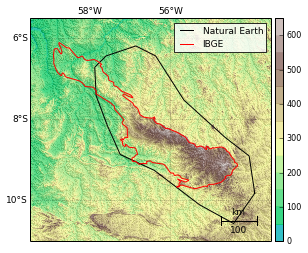

In [42]:
m = Basemap(projection='merc', llcrnrlat=s_lat, urcrnrlat=n_lat, llcrnrlon=w_lon, urcrnrlon=e_lon, resolution='c')
ls = LightSource(azdeg=135,altdeg=25)
rgb = ls.shade(rast_array,plt.cm.Greys)
m_shade = m.imshow(rgb, origin='upper')
m_color = m.imshow(rast_array, origin='upper',cmap=plt.cm.terrain, alpha=0.8, vmin=-150)
bounds = range(0, roundUp(rast_max), 50)
cbar = m.colorbar(size='3%', boundaries=bounds)
cbar.ax.tick_params(labelsize=8)
m.drawmapscale(lon=e_lon-0.8, lat=s_lat+0.5, lon0=e_lon, lat0=s_lat, length=100)
xticks = np.arange(roundBase(w_lon), roundBase(e_lon), 2)
yticks = np.arange(roundBase(s_lat), roundBase(n_lat), 2)
m.drawparallels(yticks, linewidth=0.2, labels=[1,0,0,0], fontsize=9) # draw parallels
m.drawmeridians(xticks, linewidth=0.2, labels=[0,0,1,0], fontsize=9) # draw meridians
m.plot(bound_NE_lonlat[:,0], bound_NE_lonlat[:,1], c='k', label='Natural Earth', latlon=True)
m.plot(bound_5M_lonlat[:,0], bound_5M_lonlat[:,1], c='r', label=source, latlon=True)
lg = plt.legend(loc='upper right', fontsize=9)
lg.get_frame().set_alpha(.8) # A little transparency
# plt.show()
# plt.savefig(mtn + '.pdf', dpi=600, bbox_inches='tight')
# plt.clf()

**Mask original raster with shapefiles** 

Uses external `gdalwarp` utility. Pixels outside the boundary polygon will be assigned a `-9999` value.

In [16]:
# 5M limits
out_mtn = mountain + '_clip_5M.tif'
os.system('gdalwarp -overwrite -dstnodata -9999 -cutline %s %s %s' %(mtn, tiff, out_mtn))
# Natural Earth
out_NE = mountain + '_clip_NE.tif'
os.system('gdalwarp -overwrite -dstnodata -9999 -cutline %s %s %s' %(mtn_NE, tiff, out_NE))

0

**Load clipped rasters** 

The `-9999` value is set to `NaN` (Not a Number), in a masked Numpy array.

In [17]:
# 5M 
rast_clip = gdal.Open(out_mtn)
clip_bd = rast_clip.GetRasterBand(1)
clip_array = rast_clip.ReadAsArray()
clip_mask = ma.masked_where(clip_array == -9999, clip_array)
# NatEarth
rast_clip_NE = gdal.Open(out_NE)
clip_NE_bd = rast_clip_NE.GetRasterBand(1)
clip_NE_array = rast_clip_NE.ReadAsArray()
clip_NE_mask = ma.masked_where(clip_NE_array == -9999, clip_NE_array)

**Set `yres` to a positive value** 

Used to calculate the area of each pixel.

In [18]:
if ydim < 0:
    yres = ydim * -1.0

**Calculate pixel size (in km) along the N-S direction**

This value (`dy`) does not change with Latitutde

In [19]:
dy = haversine(0, 0, 0, ydim, r=6371.009)

####Calculate pixel size along the E-W direction, create array with area values

E-W dimension (`dx`) of pixels change with latitude. The `haversine` function is used to calculate it and area is approximated as `(dx * dy)`.

In [20]:
# array with indices
rows, cols = np.indices(rast_array.shape) 
nrows = rast_array.shape[0]
ncols = rast_array.shape[1]

# new array for area values
area_array = np.empty(rast_array.shape)

# nested loop to create array with area values
for row in range(nrows):
    for col in range(ncols):
        y = row
        lat = n_lat - ((y - 0.5) * yres)
        dx = haversine(0, lat, xdim, lat, r=6371.009)
        area_array[row,col] = dx * dy

####Get base statistics for clipped rasters and calculate Elevation values used in hypsometric analysis

In [21]:
# elevation 5M
stats_clip = clip_bd.GetStatistics( True, True )
clip_min = stats_clip[0]
clip_max = stats_clip[1]

# heigh of point/contour above base of basin
clip_array_comp = ma.compressed(clip_mask)
h_clip = clip_array_comp - clip_min

# total height of basin
H_clip = clip_max - clip_min

# normalize elev for hypsometric curve
elevNorm_clip = h_clip / H_clip

# elevation NatEarth
stats_clip_NE = clip_NE_bd.GetStatistics( True, True )
clip_NE_min = stats_clip_NE[0]
clip_NE_max = stats_clip_NE[1]
clip_array_NE_comp = ma.compressed(clip_NE_mask)
h_clip_NE = clip_array_NE_comp - clip_min
H_clip_NE = clip_NE_max - clip_NE_min
elevNorm_clip_NE = h_clip_NE / H_clip_NE

####Make a masked array of cell area and calculate Area values used in hypsometric analysis

In [23]:
# cell area 5M
area_clip = ma.masked_where(clip_array == -9999, area_array)
# total area of basin/area
area_clip_sum = np.sum(area_clip)
# cumulative area for hypsographyc curve
area_clip_csum = np.cumsum(ma.compressed(area_clip))
# normalized area for hypsometric curve
area_norm_clip = area_clip / area_clip_sum
area_norm_csum = np.cumsum(ma.compressed(area_norm_clip))

# cell area NatEarth
area_clip_NE = ma.masked_where(clip_NE_array == -9999, area_array)
area_clip_sum_NE = np.sum(area_clip_NE)
area_clip_csum_NE = np.cumsum(ma.compressed(area_clip_NE))
area_norm_clip_NE = area_clip_NE / area_clip_sum_NE
area_norm_csum_NE = np.cumsum(ma.compressed(area_norm_clip_NE))

####Plot hypsographic (absolute values) curve

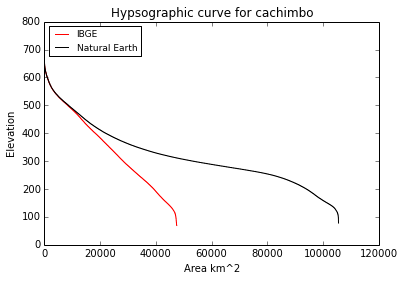

In [34]:
# 5M
plt.plot(area_clip_csum[::-1], np.sort(ma.compressed(clip_mask)), c='r', label=source)

# NatEarth
plt.plot(area_clip_csum_NE[::-1], np.sort(ma.compressed(clip_NE_mask)), c='k', label='Natural Earth')

# decorations
plt.ylabel('Elevation')
plt.xlabel('Area km^2')
plt.title('Hypsographic curve for ' + mountain)
# plt.ylim(0.0, 5000.0)
lg = plt.legend(loc='upper left', fontsize=9)
# fighist = mountain +  '_hypsographic.pdf'
# plt.savefig(fighist)
# plt.clf()

####Plot hypsometric (normalized values) curve

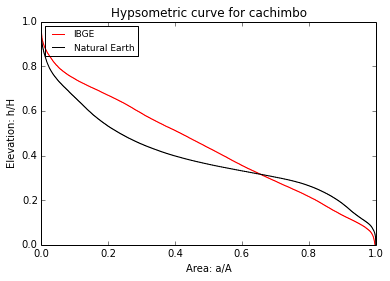

In [35]:
# 5M
plt.plot(area_norm_csum[::-1], np.sort(ma.compressed(elevNorm_clip)), c='r', label=source)

# NatEarth
plt.plot(area_norm_csum_NE[::-1], np.sort(ma.compressed(elevNorm_clip_NE)), c='k', label='Natural Earth')

# decorations
lg = plt.legend(loc='upper left', fontsize=9)
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.ylabel('Elevation: h/H')
plt.xlabel('Area: a/A')
plt.title('Hypsometric curve for ' + mountain)
# fighist = mountain + '_hypsometric.pdf'
# plt.savefig(fighist)
# plt.clf()

####Make histograms
Histograms of DEM can be of frequency (cell count per elevation) or of area per elevation. 

In [27]:
# define bins for all histograms
binsize = 50

# 5M
bins_clip = range(0, roundUp(clip_max), binsize)
bincenters = [i + binsize/2 for i in bins_clip]

# Nat Earth
bins_clip_NE = range(0, roundUp(clip_NE_max), binsize)
bincenters_NE = [i + binsize/2 for i in bins_clip_NE]

####Simple frequency (cell count) histograms

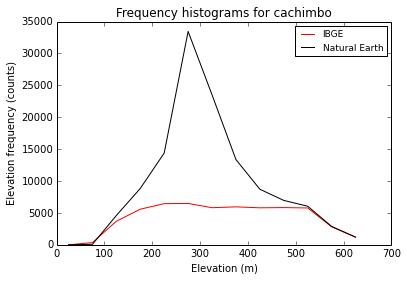

In [38]:
# 5M
vals, edges = np.histogram(clip_array_comp, bins=bins_clip)
plt.plot(bincenters[:-1], vals, c='r', label='IBGE')
# NatEarth
vals_NE, edges_NE = np.histogram(clip_array_NE_comp, bins=bins_clip_NE)
plt.plot(bincenters_NE[:-1], vals_NE, c='k', label='Natural Earth')

# decorations
lg = plt.legend(loc='upper right', fontsize=9)
plt.ylabel('Elevation frequency (counts)')
plt.xlabel('Elevation (m)')
plt.title('Frequency histograms for ' + mountain)
# plt.show()
# fighist = mountain + '_histogram_frequency.pdf'
# plt.savefig(fighist)
# plt.clf()

####Histograms of area per elevation
These can be calculated by:

1. Approximating the area by the mean cell size, where `total area = cell count * mean area of pixels`
2. Calculating area per elevation

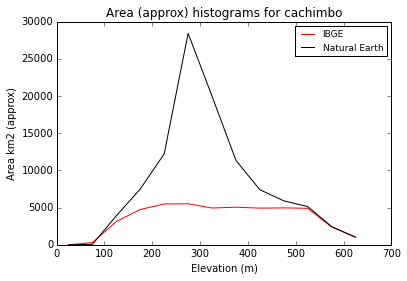

In [37]:
# i) approximating area by mean cell size
mean_area_clip = np.mean(area_clip)
mean_area_clip_NE = np.mean(area_clip_NE)

# 5M
vals, edges = np.histogram(clip_array_comp, bins=bins_clip)
plt.plot(bincenters[:-1], vals * mean_area_clip, c='r', label='IBGE')

# NatEarth
vals_NE, edges_NE = np.histogram(clip_array_NE_comp, bins=bins_clip_NE)
plt.plot(bincenters_NE[:-1], vals_NE * mean_area_clip_NE, c='k', label='Natural Earth')

# decorations
lg = plt.legend(loc='upper right', fontsize=9)
plt.ylabel('Area km2 (approx)')
plt.xlabel('Elevation (m)')
plt.title('Area (approx) histograms for ' + mountain)
# plt.show()
# fighist = mountain + '_histogram_area_approx.pdf'
# plt.savefig(fighist)
# plt.clf()

To calculate the area of pixels per elevation, we use the `ndimage` function from SciPy. It sums the values in one array (area) based on occurence a second array (elevation). A third array is used as an index (from 0 to max+1).

In [31]:
# ii) calculating area per elevation

# 5M data
clip_range = np.arange(0, int(clip_max)+1)

sum_area_clip = ndimage.sum(area_array, clip_array, clip_range)

# sum the values of areas in each bin
bins_sum = []
for i in bincenters:
    low = i - (binsize / 2)
    up = i + (binsize / 2)
    b_sum = np.sum(sum_area_clip[low:up])
    bins_sum.append(b_sum)
    
    
    
# Natural Earth
clip_range_NE = np.arange(0, int(clip_NE_max)+1)

sum_area_clip = ndimage.sum(area_array, clip_NE_array, clip_range_NE)

bins_sum_NE = []
for i in bincenters_NE:
    low = i - (binsize / 2)
    up = i + (binsize / 2)
    b_sum = np.sum(sum_area_clip[low:up])
    bins_sum_NE.append(b_sum)

####Plot histograms 

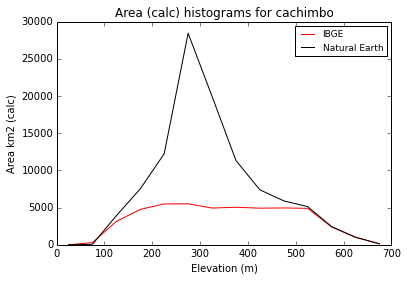

In [36]:
# 5M
plt.plot(bincenters, bins_sum, c='r', label='IBGE')

# Natural Earth
plt.plot(bincenters_NE, bins_sum_NE, c='k', label='Natural Earth')

# decorations
lg = plt.legend(loc='upper right', fontsize=9)
plt.ylabel('Area km2 (calc)')
plt.xlabel('Elevation (m)')
plt.title('Area (calc) histograms for ' + mountain)
# plt.show()
# fighist = mountain +  '_histogram_area_calc.pdf'
# plt.savefig(fighist)
# plt.clf()

We can compare both methods and see that approximating the area of pixels by the mean cell size gives results very close to those obtained by calculating the area of each pixel.

#colocar comparação dos dois